# Import modules

In [1]:
import h5py
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

# Opmitize performance

In [2]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


# Open dataset in the hdf5 files

In [3]:
# Open training dataset
with h5py.File("Dataset/dataset_training.h5", "r") as hdf5_file:
    images_training = hdf5_file["images"][:]
    labels_training = hdf5_file["labels"][:]
print(images_training.shape, labels_training.shape)

# Open testing dataset
with h5py.File("Dataset/dataset_testing.h5", "r") as hdf5_file:
    images_testing = hdf5_file["images"][:]
    labels_testing = hdf5_file["labels"][:]
print(images_testing.shape, labels_testing.shape)

(2870, 256, 256, 3) (2870,)
(394, 256, 256, 3) (394,)


# Split training dataset into train and validation with 80-20 porportion

In [4]:
images_training, images_validation, labels_training, labels_validation = train_test_split(images_training, labels_training, test_size=0.2)
print(images_training.shape, labels_training.shape)
print(images_validation.shape, labels_validation.shape)

(2296, 256, 256, 3) (2296,)
(574, 256, 256, 3) (574,)


In [5]:
classes = {0 : 'glioma_tumor',
           1 : 'meningioma_tumor',
           2 : 'normal',
           3 : 'pituitary_tumor'}

In [6]:
images_training.shape[0]

2296

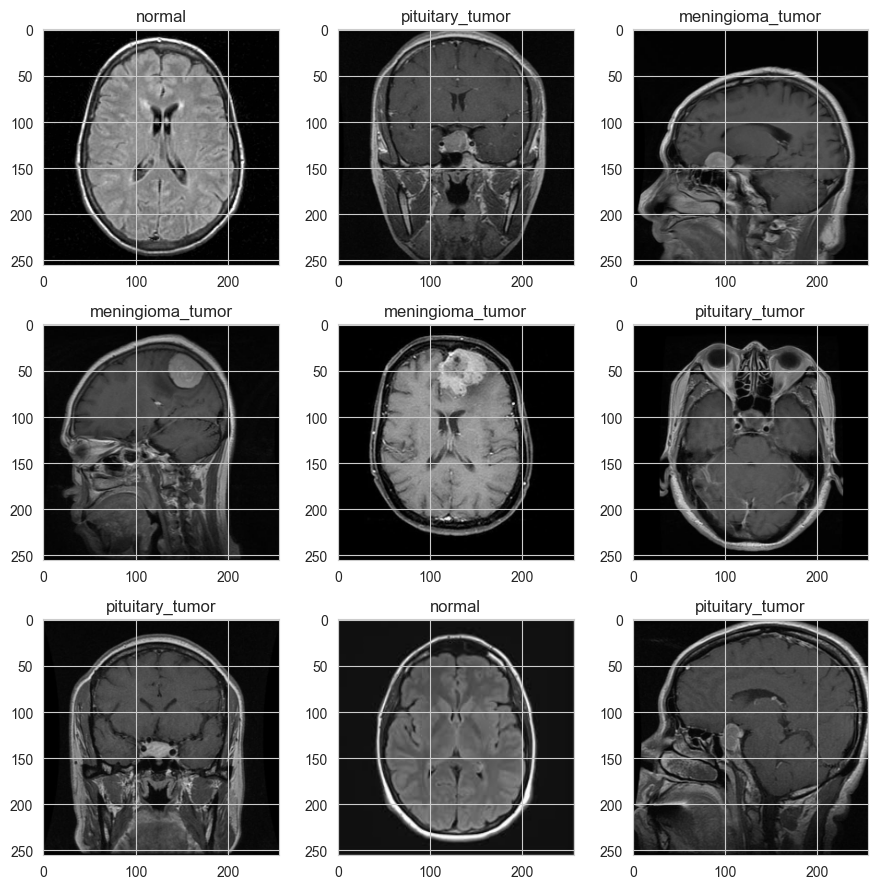

In [7]:
# Create a 1x4 plot
plt.figure(figsize=(9, 9))

for i in range(1,10):
    plt.subplot(3, 3, i)
    index_random = random.randint(0,images_training.shape[0])
    plt.imshow(images_training[index_random])
    plt.title(classes[labels_training[index_random]])
# Display the plot
plt.tight_layout()
plt.show()

# Some important functions to show results

In [8]:
def plot_history(historical):
  epochs = range(1, len(historical.history['loss'])+1)

  plt.figure(figsize = (12,4))


  plt.subplot(1,2,1)
  plt.plot(epochs, historical.history['loss'], label = 'Trainning loss')
  plt.plot(epochs, historical.history['val_loss'], label = 'validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Trainning and validation loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, historical.history['accuracy'], label = 'Trainning accuracy')
  plt.plot(epochs, historical.history['val_accuracy'], label = 'validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.title('Trainning and validation accuracy')
  plt.legend()
  plt.ylim(0, 1.1)

In [9]:
def confusionMatrix_and_Report(y_pred, y_test, labels):
  cm = confusion_matrix(y_test, y_pred, )
  #print(type(cm), cm)
  cm = pd.DataFrame(cm,  range(4),range(4))
  x_axis_labels = labels
  y_axis_labels = labels
  plt.figure(figsize = (6,6))
  ax = sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 12}, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar=False) # font size
  ax.xaxis.tick_top() # x axis on top
  ax.xaxis.set_label_position('top')
  plt.show()

  reporte = classification_report(y_test, y_pred, target_names = labels)
  print(reporte)

In [10]:
def save_model_and_store_history(model, history, name):
    try:
        model.save('Saved_models_and_history/'+name)
        history_dict = {'accuracy': history.history['accuracy'],
                        'loss': history.history['loss'],
                        'val_accuracy' : history.history['val_accuracy'],
                        'val_loss' : history.history['val_loss']
                        }
        with open('Saved_models_and_history/'+name+'_history.json', 'w') as json_file:
            json.dump(history_dict, json_file)
    except:
        print('The folder to store the model and the history does not exists, please create it before run save_model_and_store_history')

# Create preprocessing Net, it will be connected at the beggining of custom Nets, before apply transfer learning

In [11]:
# Define data augmentation parameters
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),  # Horizontal flip
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),  # Random rotation up to 30 degrees
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),  # Random zoom up to 15%
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=.15, width_factor=.15),  # Random shear up to 20%
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0, input_shape=(256, 256, 3))
])

# Custom VGG16

In [12]:
vgg_16 = keras.applications.VGG16(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in vgg_16.layers:
  layer.trainable = False

vgg16_modified = Sequential()

#Preprocessing layers
vgg16_modified.add(data_augmentation)

vgg16_modified.add(vgg_16)
vgg16_modified.add(Flatten())
vgg16_modified.add(Dense(64, activation = 'relu'))
vgg16_modified.add(Dense(128, activation = 'relu'))
vgg16_modified.add(Dense(4, activation = 'softmax'))


vgg16_modified.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])
#vgg16_modified.summary()

## Train custom VGG 16

Epoch 1/20
72/72 [==============================] - 13s 136ms/step - loss: 0.9516 - accuracy: 0.6045 - val_loss: 0.5815 - val_accuracy: 0.7561
Epoch 2/20
72/72 [==============================] - 9s 121ms/step - loss: 0.6138 - accuracy: 0.7461 - val_loss: 0.5197 - val_accuracy: 0.7979
Epoch 3/20
72/72 [==============================] - 9s 121ms/step - loss: 0.5332 - accuracy: 0.7840 - val_loss: 0.4908 - val_accuracy: 0.8153
Epoch 4/20
72/72 [==============================] - 9s 121ms/step - loss: 0.4765 - accuracy: 0.8105 - val_loss: 0.4568 - val_accuracy: 0.8328
Epoch 5/20
72/72 [==============================] - 9s 121ms/step - loss: 0.4405 - accuracy: 0.8262 - val_loss: 0.4735 - val_accuracy: 0.8223
Epoch 6/20
72/72 [==============================] - 9s 121ms/step - loss: 0.4501 - accuracy: 0.8271 - val_loss: 0.3961 - val_accuracy: 0.8467
Epoch 7/20
72/72 [==============================] - 9s 121ms/step - loss: 0.4018 - accuracy: 0.8419 - val_loss: 0.3699 - val_accuracy: 0.8467
Epoch

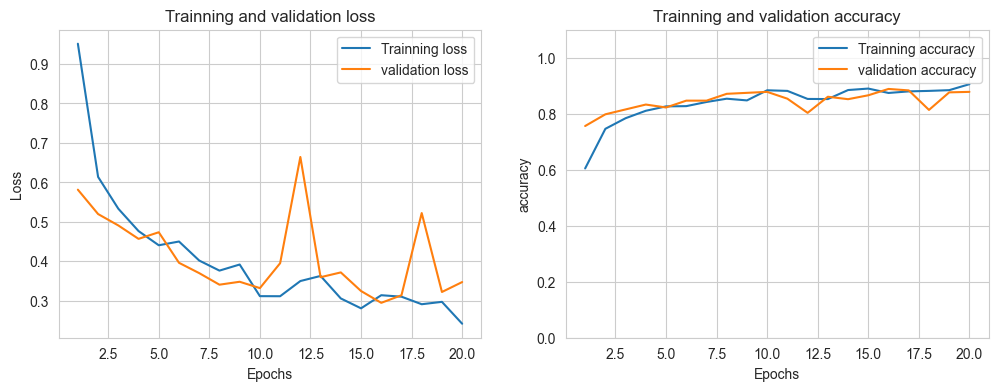

In [13]:
historical_vgg16 = vgg16_modified.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    validation_data = (images_validation, to_categorical(labels_validation)),
                                    )
plot_history(historical_vgg16)

## Predict with testing data and get metrics

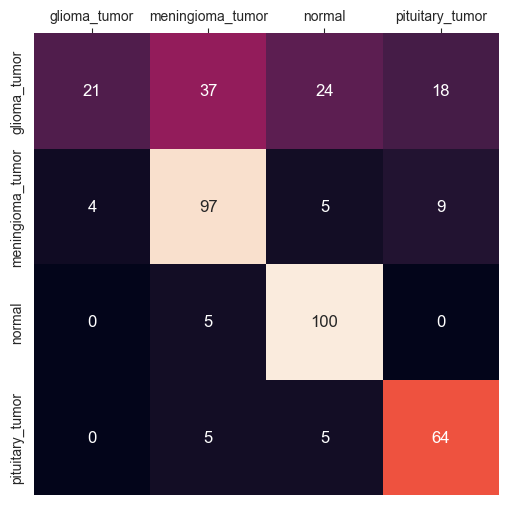

                  precision    recall  f1-score   support

    glioma_tumor       0.84      0.21      0.34       100
meningioma_tumor       0.67      0.84      0.75       115
          normal       0.75      0.95      0.84       105
 pituitary_tumor       0.70      0.86      0.78        74

        accuracy                           0.72       394
       macro avg       0.74      0.72      0.67       394
    weighted avg       0.74      0.72      0.67       394



In [14]:
y_pred = vgg16_modified.predict(images_testing)
y_pred = np.argmax(y_pred, axis = 1)
confusionMatrix_and_Report(y_pred, labels_testing, list(classes.values()))

# Save model as h5 file and store historical as json, then free model from memory

In [15]:
save_model_and_store_history(vgg16_modified, historical_vgg16, 'vgg16_modified')
del vgg16_modified, historical_vgg16

INFO:tensorflow:Assets written to: Saved_models_and_history/vgg16_modified\assets


# Own model V2

Epoch 1/20
72/72 [==============================] - 19s 211ms/step - loss: 11.8430 - accuracy: 0.4756 - val_loss: 0.8161 - val_accuracy: 0.6463
Epoch 2/20
72/72 [==============================] - 13s 178ms/step - loss: 0.8680 - accuracy: 0.6755 - val_loss: 0.8250 - val_accuracy: 0.6568
Epoch 3/20
72/72 [==============================] - 13s 175ms/step - loss: 0.7825 - accuracy: 0.6956 - val_loss: 0.6869 - val_accuracy: 0.7195
Epoch 4/20
72/72 [==============================] - 12s 165ms/step - loss: 0.6832 - accuracy: 0.7291 - val_loss: 0.6457 - val_accuracy: 0.7456
Epoch 5/20
72/72 [==============================] - 12s 164ms/step - loss: 0.6062 - accuracy: 0.7605 - val_loss: 0.6153 - val_accuracy: 0.7544
Epoch 6/20
72/72 [==============================] - 12s 163ms/step - loss: 0.5050 - accuracy: 0.7970 - val_loss: 0.5524 - val_accuracy: 0.7944
Epoch 7/20
72/72 [==============================] - 12s 162ms/step - loss: 0.4716 - accuracy: 0.8219 - val_loss: 0.4835 - val_accuracy: 0.825

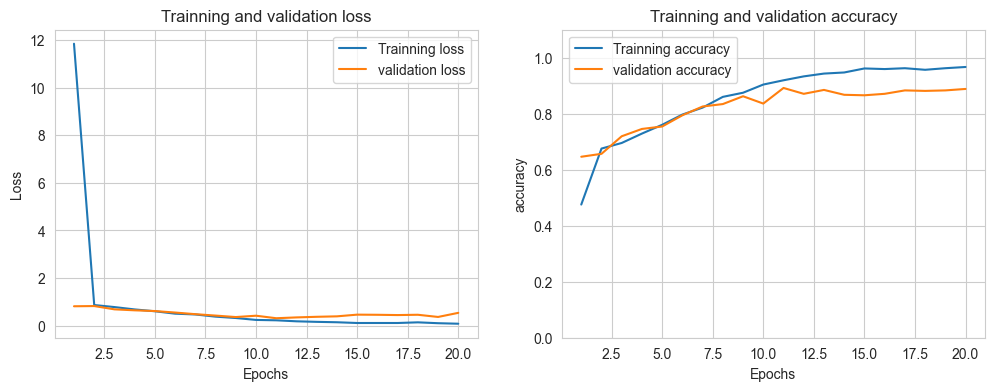

In [16]:
model_v2 = Sequential()

model_v2.add(Conv2D(128, (3, 3), input_shape=( 256, 256, 3), activation='relu'))
model_v2.add(MaxPooling2D(pool_size=(2, 2)))

model_v2.add(Conv2D(128, (3, 3), activation='relu'))
model_v2.add(MaxPooling2D(pool_size=(2, 2)))

model_v2.add(Conv2D(128, (3, 3), activation='relu'))
model_v2.add(MaxPooling2D(pool_size=(2, 2)))

model_v2.add(Flatten())

model_v2.add(Dense(128, activation='relu'))
model_v2.add(Dropout(0.33))

model_v2.add(Dense(256, activation = 'relu'))
model_v2.add(Dropout(0.5))

model_v2.add(Dense(4, activation = 'softmax'))


model_v2.compile(#loss='sparse_categorical_crossentropy',
                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer= "adam",
              metrics=['accuracy'],
              )

model_v2_history = model_v2.fit(x = images_training,
            y = to_categorical(labels_training),
            batch_size=32,
            epochs=20,
            validation_data = (images_validation, to_categorical(labels_validation)),
            #callbacks=[tensorboard,es],
            )
plot_history(model_v2_history)

## Predict on testing data and get metrics

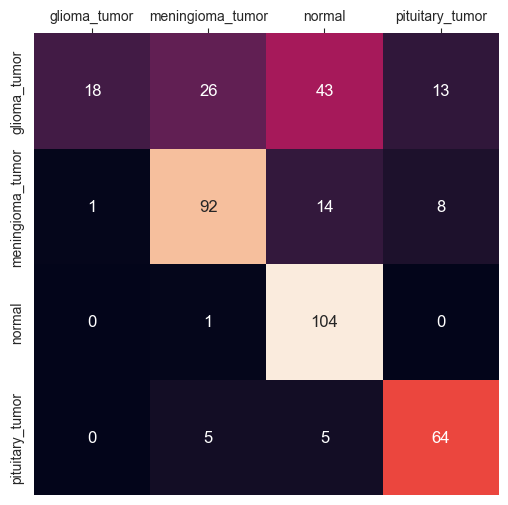

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.18      0.30       100
meningioma_tumor       0.74      0.80      0.77       115
          normal       0.63      0.99      0.77       105
 pituitary_tumor       0.75      0.86      0.81        74

        accuracy                           0.71       394
       macro avg       0.77      0.71      0.66       394
    weighted avg       0.77      0.71      0.66       394



In [17]:
y_pred = model_v2.predict(images_testing)
y_pred = np.argmax(y_pred, axis = 1)
confusionMatrix_and_Report(y_pred, labels_testing, list(classes.values()))

# Save model as h5 file and store historical as json, then free model from memory

In [18]:
save_model_and_store_history(model_v2, model_v2_history, 'model_v2')
del model_v2, model_v2_history

INFO:tensorflow:Assets written to: Saved_models_and_history/model_v2\assets


# ResNet50V2

Epoch 1/20
72/72 [==============================] - 7s 58ms/step - loss: 2.9350 - accuracy: 0.6302 - val_loss: 0.9065 - val_accuracy: 0.7700
Epoch 2/20
72/72 [==============================] - 4s 50ms/step - loss: 0.6460 - accuracy: 0.7827 - val_loss: 0.4919 - val_accuracy: 0.8275
Epoch 3/20
72/72 [==============================] - 4s 53ms/step - loss: 0.5717 - accuracy: 0.8036 - val_loss: 0.5220 - val_accuracy: 0.8171
Epoch 4/20
72/72 [==============================] - 4s 52ms/step - loss: 0.5325 - accuracy: 0.8193 - val_loss: 0.4061 - val_accuracy: 0.8502
Epoch 5/20
72/72 [==============================] - 4s 52ms/step - loss: 0.4432 - accuracy: 0.8454 - val_loss: 0.3655 - val_accuracy: 0.8659
Epoch 6/20
72/72 [==============================] - 4s 52ms/step - loss: 0.3685 - accuracy: 0.8641 - val_loss: 0.4335 - val_accuracy: 0.8380
Epoch 7/20
72/72 [==============================] - 4s 52ms/step - loss: 0.3253 - accuracy: 0.8828 - val_loss: 0.3360 - val_accuracy: 0.8868
Epoch 8/20
72

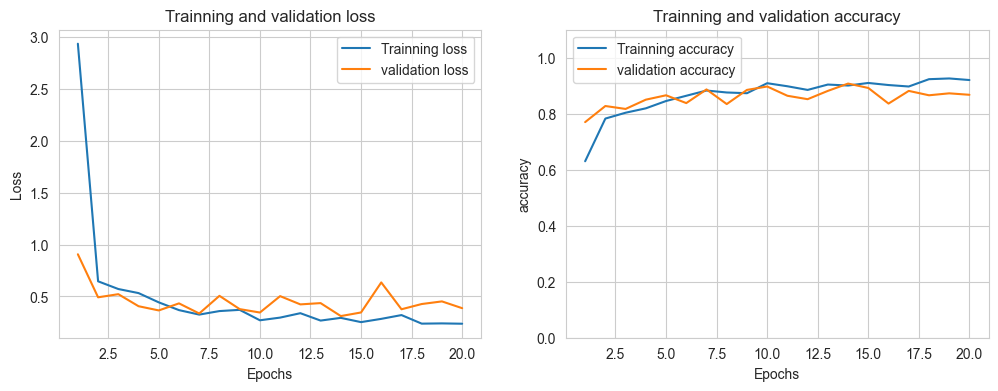

In [19]:
ResNet50v2 = keras.applications.ResNet50V2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in ResNet50v2.layers:
  layer.trainable = False

ResNet50v2_custom = Sequential()

#Preprocessing layers
ResNet50v2_custom.add(data_augmentation)

ResNet50v2_custom.add(ResNet50v2)
ResNet50v2_custom.add(Flatten())
ResNet50v2_custom.add(Dense(64, activation = 'relu'))
ResNet50v2_custom.add(Dense(128, activation = 'relu'))
ResNet50v2_custom.add(Dense(4, activation = 'softmax'))


ResNet50v2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

historical_ResNet50v2 = ResNet50v2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    validation_data = (images_validation, to_categorical(labels_validation)),
                                    )
plot_history(historical_ResNet50v2)

## Predict on testing data and get metrics

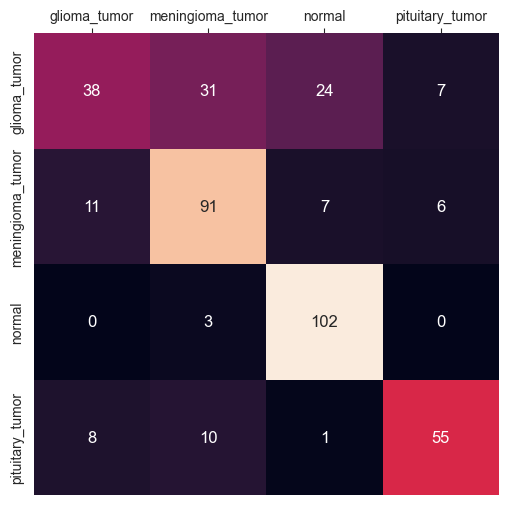

                  precision    recall  f1-score   support

    glioma_tumor       0.67      0.38      0.48       100
meningioma_tumor       0.67      0.79      0.73       115
          normal       0.76      0.97      0.85       105
 pituitary_tumor       0.81      0.74      0.77        74

        accuracy                           0.73       394
       macro avg       0.73      0.72      0.71       394
    weighted avg       0.72      0.73      0.71       394



In [20]:
y_pred = ResNet50v2_custom.predict(images_testing)
y_pred = np.argmax(y_pred, axis = 1)
confusionMatrix_and_Report(y_pred, labels_testing, list(classes.values()))

# Save model as h5 file and store historical as json, then free model from memory

In [21]:
save_model_and_store_history(ResNet50v2_custom, historical_ResNet50v2, 'ResNet50v2_custom')
del ResNet50v2_custom, historical_ResNet50v2

INFO:tensorflow:Assets written to: Saved_models_and_history/ResNet50v2_custom\assets


C:\Users\Edgar\anaconda3\envs\TF_python_37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# InceptionResNetv2

Epoch 1/20
72/72 [==============================] - 20s 165ms/step - loss: 2.9238 - accuracy: 0.5745 - val_loss: 0.7007 - val_accuracy: 0.7561
Epoch 2/20
72/72 [==============================] - 10s 134ms/step - loss: 0.6040 - accuracy: 0.7740 - val_loss: 0.4030 - val_accuracy: 0.8432
Epoch 3/20
72/72 [==============================] - 10s 133ms/step - loss: 0.6349 - accuracy: 0.7753 - val_loss: 0.6152 - val_accuracy: 0.7718
Epoch 4/20
72/72 [==============================] - 10s 133ms/step - loss: 0.5076 - accuracy: 0.8136 - val_loss: 0.8193 - val_accuracy: 0.7422
Epoch 5/20
72/72 [==============================] - 10s 133ms/step - loss: 0.5114 - accuracy: 0.8132 - val_loss: 0.3702 - val_accuracy: 0.8763
Epoch 6/20
72/72 [==============================] - 10s 133ms/step - loss: 0.4464 - accuracy: 0.8380 - val_loss: 0.5387 - val_accuracy: 0.8293
Epoch 7/20
72/72 [==============================] - 9s 130ms/step - loss: 0.4705 - accuracy: 0.8219 - val_loss: 0.4047 - val_accuracy: 0.8571


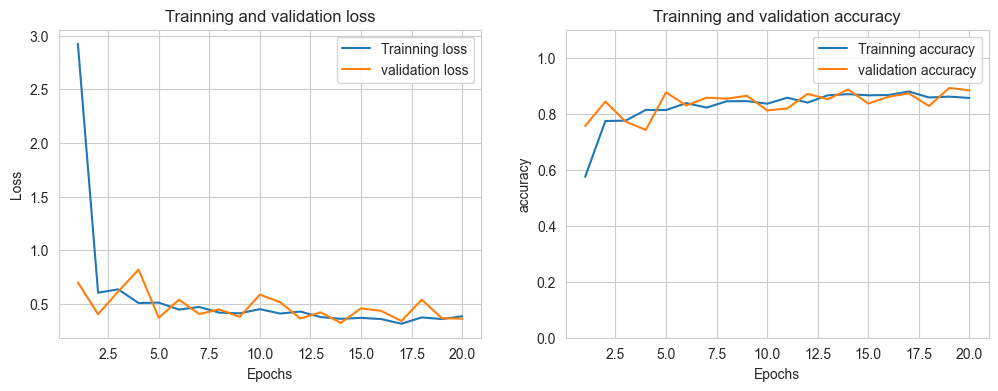

In [22]:
InceptionResNetv2 = keras.applications.InceptionResNetV2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in InceptionResNetv2.layers:
  layer.trainable = False

InceptionResNetv2_custom = Sequential()

#Preprocessing layers
InceptionResNetv2_custom.add(data_augmentation)

InceptionResNetv2_custom.add(InceptionResNetv2)
InceptionResNetv2_custom.add(Flatten())
InceptionResNetv2_custom.add(Dense(64, activation = 'relu'))
InceptionResNetv2_custom.add(Dense(128, activation = 'relu'))
InceptionResNetv2_custom.add(Dense(4, activation = 'softmax'))


InceptionResNetv2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

historical_InceptionResNetv2 = InceptionResNetv2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    validation_data = (images_validation, to_categorical(labels_validation)),
                                    )
plot_history(historical_InceptionResNetv2)

## Predict on testing data and get metrics

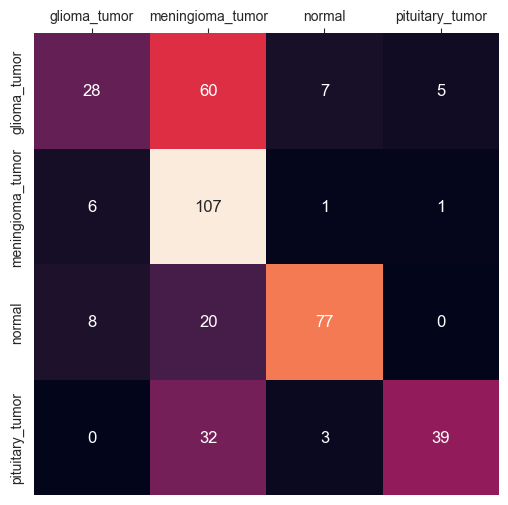

                  precision    recall  f1-score   support

    glioma_tumor       0.67      0.28      0.39       100
meningioma_tumor       0.49      0.93      0.64       115
          normal       0.88      0.73      0.80       105
 pituitary_tumor       0.87      0.53      0.66        74

        accuracy                           0.64       394
       macro avg       0.72      0.62      0.62       394
    weighted avg       0.71      0.64      0.62       394



In [23]:
y_pred = InceptionResNetv2_custom.predict(images_testing)
y_pred = np.argmax(y_pred, axis = 1)
confusionMatrix_and_Report(y_pred, labels_testing, list(classes.values()))

# Save model as h5 file and store historical as json, then free model from memory

In [24]:
save_model_and_store_history(InceptionResNetv2_custom, historical_InceptionResNetv2, 'InceptionResNetv2_custom')
del InceptionResNetv2_custom, historical_InceptionResNetv2

INFO:tensorflow:Assets written to: Saved_models_and_history/InceptionResNetv2_custom\assets


# MobileNetv2

Epoch 1/20
72/72 [==============================] - 11s 112ms/step - loss: 1.6572 - accuracy: 0.6446 - val_loss: 0.6244 - val_accuracy: 0.7648
Epoch 2/20
72/72 [==============================] - 7s 101ms/step - loss: 0.5028 - accuracy: 0.8088 - val_loss: 0.5147 - val_accuracy: 0.8118
Epoch 3/20
72/72 [==============================] - 7s 101ms/step - loss: 0.4469 - accuracy: 0.8319 - val_loss: 0.6621 - val_accuracy: 0.7700
Epoch 4/20
72/72 [==============================] - 7s 100ms/step - loss: 0.4198 - accuracy: 0.8410 - val_loss: 0.4930 - val_accuracy: 0.8275
Epoch 5/20
72/72 [==============================] - 7s 99ms/step - loss: 0.3953 - accuracy: 0.8589 - val_loss: 0.7036 - val_accuracy: 0.7787
Epoch 6/20
72/72 [==============================] - 7s 99ms/step - loss: 0.3448 - accuracy: 0.8776 - val_loss: 0.6795 - val_accuracy: 0.7787
Epoch 7/20
72/72 [==============================] - 7s 99ms/step - loss: 0.3681 - accuracy: 0.8672 - val_loss: 0.5348 - val_accuracy: 0.8171
Epoch 8/

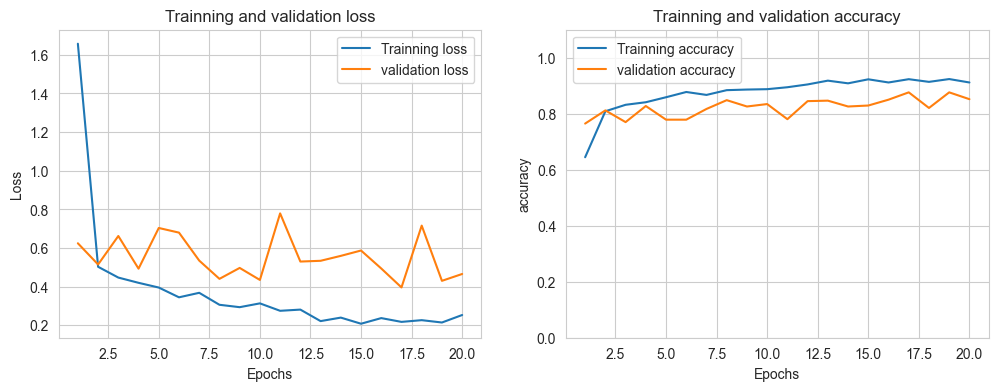

In [25]:
MobileNetv2 = keras.applications.MobileNetV2(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in MobileNetv2.layers:
  layer.trainable = False

MobileNetv2_custom = Sequential()

#Preprocessing layers
MobileNetv2_custom.add(data_augmentation)

MobileNetv2_custom.add(MobileNetv2)
MobileNetv2_custom.add(Flatten())
MobileNetv2_custom.add(Dense(64, activation = 'relu'))
MobileNetv2_custom.add(Dense(128, activation = 'relu'))
MobileNetv2_custom.add(Dense(4, activation = 'softmax'))


MobileNetv2_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

historical_MobileNetv2 = MobileNetv2_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    validation_data = (images_validation, to_categorical(labels_validation)),
                                    )
plot_history(historical_MobileNetv2)

## Predict on testing data and get metrics

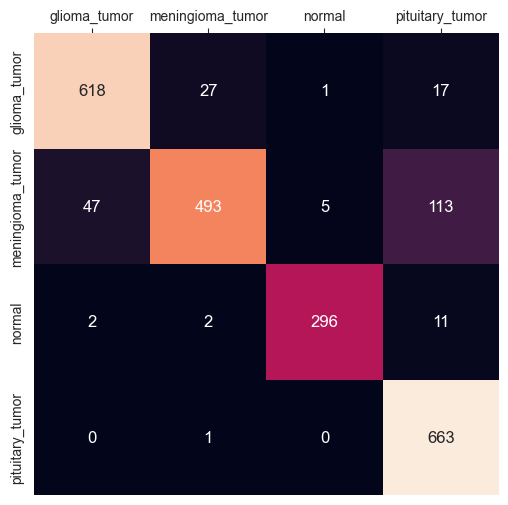

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.93      0.93       663
meningioma_tumor       0.94      0.75      0.83       658
          normal       0.98      0.95      0.97       311
 pituitary_tumor       0.82      1.00      0.90       664

        accuracy                           0.90      2296
       macro avg       0.92      0.91      0.91      2296
    weighted avg       0.91      0.90      0.90      2296



In [26]:
y_pred_train = MobileNetv2_custom.predict(images_training)
confusionMatrix_and_Report(np.argmax(y_pred_train, axis = 1),
                           labels_training,
                           list(classes.values()))

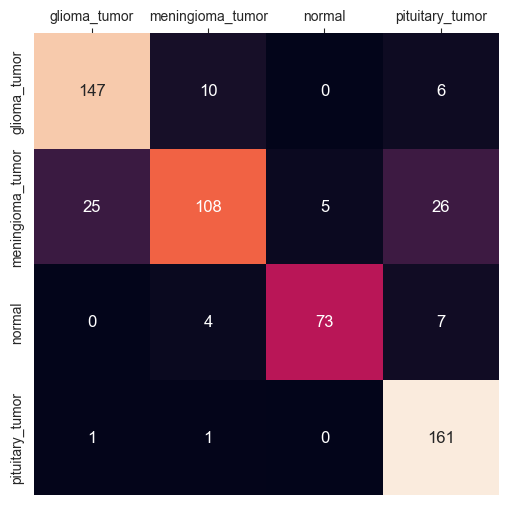

                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.90      0.87       163
meningioma_tumor       0.88      0.66      0.75       164
          normal       0.94      0.87      0.90        84
 pituitary_tumor       0.81      0.99      0.89       163

        accuracy                           0.85       574
       macro avg       0.87      0.85      0.85       574
    weighted avg       0.86      0.85      0.85       574



In [27]:
y_pred_val = MobileNetv2_custom.predict(images_validation)
confusionMatrix_and_Report(np.argmax(y_pred_val, axis = 1),
                           labels_validation,
                           list(classes.values()))

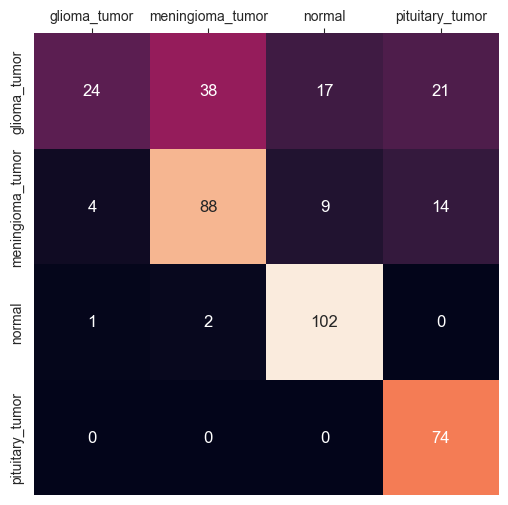

                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.24      0.37       100
meningioma_tumor       0.69      0.77      0.72       115
          normal       0.80      0.97      0.88       105
 pituitary_tumor       0.68      1.00      0.81        74

        accuracy                           0.73       394
       macro avg       0.75      0.74      0.70       394
    weighted avg       0.75      0.73      0.69       394



In [28]:
y_pred_test = MobileNetv2_custom.predict(images_testing)
confusionMatrix_and_Report(np.argmax(y_pred_test, axis = 1),
                           labels_testing,
                           list(classes.values()))

# Save model as h5 file and store historical as json, then free model from memory

In [29]:
save_model_and_store_history(MobileNetv2_custom, historical_MobileNetv2, 'MobileNetv2_custom')
del MobileNetv2_custom, historical_MobileNetv2

INFO:tensorflow:Assets written to: Saved_models_and_history/MobileNetv2_custom\assets


C:\Users\Edgar\anaconda3\envs\TF_python_37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# EfficientNet_B3

Epoch 1/20
72/72 [==============================] - 27s 277ms/step - loss: 5.1188 - accuracy: 0.2740 - val_loss: 1.6223 - val_accuracy: 0.2840
Epoch 2/20
72/72 [==============================] - 17s 240ms/step - loss: 1.6236 - accuracy: 0.2652 - val_loss: 1.5321 - val_accuracy: 0.1463
Epoch 3/20
72/72 [==============================] - 17s 236ms/step - loss: 1.7049 - accuracy: 0.2700 - val_loss: 1.4926 - val_accuracy: 0.1463
Epoch 4/20
72/72 [==============================] - 17s 236ms/step - loss: 1.5040 - accuracy: 0.2861 - val_loss: 1.3825 - val_accuracy: 0.2840
Epoch 5/20
72/72 [==============================] - 17s 236ms/step - loss: 1.4738 - accuracy: 0.2748 - val_loss: 1.3855 - val_accuracy: 0.2857
Epoch 6/20
72/72 [==============================] - 17s 236ms/step - loss: 1.4189 - accuracy: 0.2892 - val_loss: 1.4070 - val_accuracy: 0.2997
Epoch 7/20
72/72 [==============================] - 17s 236ms/step - loss: 1.4166 - accuracy: 0.2792 - val_loss: 1.3809 - val_accuracy: 0.2840

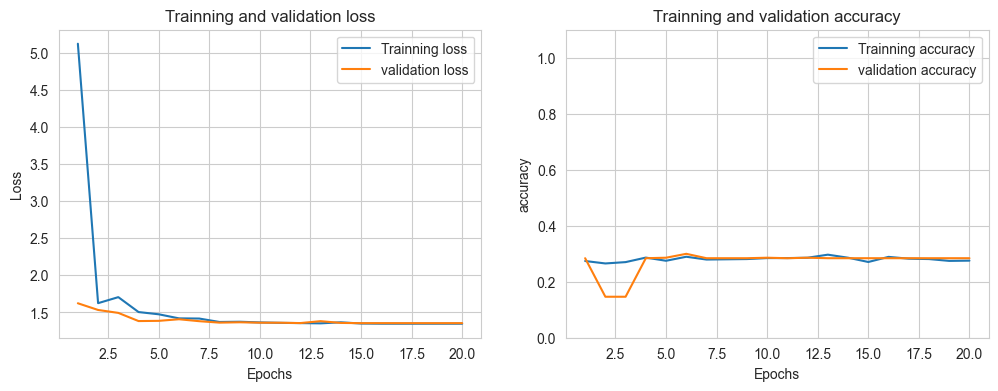

In [30]:
EfficientNet_B3 = keras.applications.EfficientNetB3(weights='imagenet', include_top = False, input_shape=(256,256,3))

for layer in EfficientNet_B3.layers:
  layer.trainable = False

EfficientNetB3_custom = Sequential()

#Preprocessing layers
EfficientNetB3_custom.add(data_augmentation)

EfficientNetB3_custom.add(EfficientNet_B3)
EfficientNetB3_custom.add(Flatten())
EfficientNetB3_custom.add(Dense(64, activation = 'relu'))
EfficientNetB3_custom.add(Dense(128, activation = 'relu'))
EfficientNetB3_custom.add(Dense(4, activation = 'softmax'))


EfficientNetB3_custom.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           #optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, nesterov=True),
                           #loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,name='binary_crossentropy'),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                           metrics = ['accuracy'])

historical_EfficientNetB3 = EfficientNetB3_custom.fit(x = images_training,
                                    y = to_categorical(labels_training),
                                    epochs = 20,
                                    batch_size = 32,
                                    validation_data = (images_validation, to_categorical(labels_validation)),
                                    )
plot_history(historical_EfficientNetB3)

## Predict on testing data and get metrics

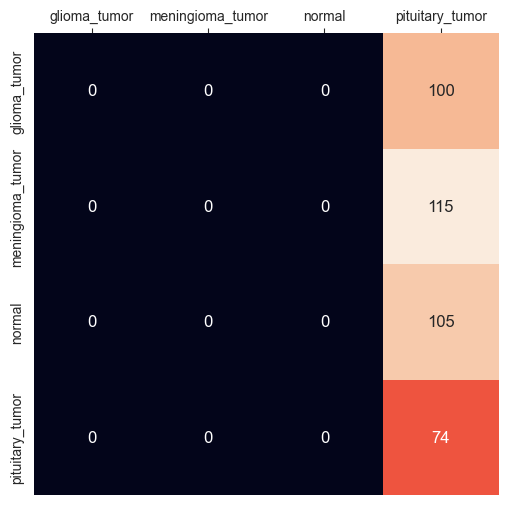

                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.00      0.00      0.00       115
          normal       0.00      0.00      0.00       105
 pituitary_tumor       0.19      1.00      0.32        74

        accuracy                           0.19       394
       macro avg       0.05      0.25      0.08       394
    weighted avg       0.04      0.19      0.06       394



C:\Users\Edgar\anaconda3\envs\TF_python_37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Edgar\anaconda3\envs\TF_python_37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Edgar\anaconda3\envs\TF_python_37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
y_pred = EfficientNetB3_custom.predict(images_testing)
y_pred = np.argmax(y_pred, axis = 1)
confusionMatrix_and_Report(y_pred, labels_testing, list(classes.values()))

# Save model as h5 file and store historical as json, then free model from memory

In [32]:
save_model_and_store_history(EfficientNetB3_custom, historical_EfficientNetB3, 'EfficientNetB3_custom')
del EfficientNetB3_custom, historical_EfficientNetB3

INFO:tensorflow:Assets written to: Saved_models_and_history/EfficientNetB3_custom\assets


C:\Users\Edgar\anaconda3\envs\TF_python_37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
